In [20]:
import math
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 10)
pd.set_option("display.width", 150)
import graphviz
import networkx as nx
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Helvetica'
mpl.rcParams['mathtext.fontset'] = 'cm'
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy.interpolate import interp1d

In [39]:
df = pd.read_csv('data/selected-ortho-edges.csv', index_col=0)
df.rename(columns={'category': 'cat'}, inplace=True)
dict_order = {
    'Chromatin remodeling': 1,
    'Transcriptional regulation': 2,
    'Post-transcriptional reg.': 3,
    'piRNA': 4,
    'Circadian clock': 5,
    'Pre-mRNA regulation': 6,
    'RNA modification': 7,
    'rRNA': 8
}
dict_facecolor = {
    1: '#1f77b4',
    2: '#ff7f0e',
    3: '#2ca02c',
    4: '#d62728',
    5: '#9467bd',
    6: '#8c564b',
    7: '#e377c2',
    8: '#bcbd22',
}
dict_edgecolor = {
    1: '#aec7e8',
    2: '#ffbb78',
    3: '#98df8a',
    4: '#ff9896',
    5: '#c5b0d5',
    6: '#c49c94',    
    7: '#f7b6d2',
    8: '#dbdb8d',
}
df['order'] = df['cat'].map(dict_order)
df['facecolor'] = df['order'].map(dict_facecolor)
df['edgecolor'] = df['order'].map(dict_edgecolor)
df.sort_values(['gene_i', 'gene_j'], inplace=True)
display(df)

,id_gene_i,id_gene_j,gene_i,gene_j,weight,cat,order,facecolor,edgecolor
20,ENSG00000072364,ENSG00000129315,AFF4,CCNT1,0.999,Transcriptional regulation,2,#ff7f0e,#ffbb78
22,ENSG00000072364,ENSG00000130382,AFF4,MLLT1,0.990,Transcriptional regulation,2,#ff7f0e,#ffbb78
30,ENSG00000133794,ENSG00000134852,ARNTL,CLOCK,0.999,Circadian clock,5,#9467bd,#c5b0d5
32,ENSG00000133794,ENSG00000008405,ARNTL,CRY1,0.999,Circadian clock,5,#9467bd,#c5b0d5
31,ENSG00000133794,ENSG00000121671,ARNTL,CRY2,0.999,Circadian clock,5,#9467bd,#c5b0d5
...,...,...,...,...,...,...,...,...,...
1181,ENSG00000253797,ENSG00000108651,UTP14C,UTP6,0.997,rRNA,8,#bcbd22,#dbdb8d
1209,ENSG00000136709,ENSG00000165934,WDR33,CPSF2,0.999,Pre-mRNA regulation,6,#8c564b,#c49c94
1210,ENSG00000136709,ENSG00000119203,WDR33,CPSF3,0.999,Pre-mRNA regulation,6,#8c564b,#c49c94
1216,ENSG00000136709,ENSG00000160917,WDR33,CPSF4,0.999,Pre-mRNA regulation,6,#8c564b,#c49c94


In [40]:
# Graph from edgelisrt
G = nx.from_pandas_edgelist(df, source='id_gene_i', target='id_gene_j', edge_attr=['weight', 'facecolor', 'edgecolor'], create_using=nx.DiGraph)
# Name
series_names = pd.concat([df.set_index('id_gene_i')['gene_i'], df.set_index('id_gene_j')['gene_j']]).drop_duplicates()
dict_names = series_names.to_dict()
nx.set_node_attributes(G, name='name', values=dict_names)
# Category
series_cat = pd.concat([df.set_index('id_gene_i')['cat'], df.set_index('id_gene_j')['cat']])
nx.set_node_attributes(G, values=series_cat.to_dict(), name='cat')
# Color
series_facecolor = pd.concat([df.set_index('id_gene_i')['facecolor'], df.set_index('id_gene_j')['facecolor']])
series_edgecolor = pd.concat([df.set_index('id_gene_i')['edgecolor'], df.set_index('id_gene_j')['edgecolor']])
nx.set_node_attributes(G, values=series_facecolor.to_dict(), name='facecolor')
nx.set_node_attributes(G, values=series_edgecolor.to_dict(), name='edgecolor')
# Order
series_order = pd.concat([df.set_index('id_gene_i')['order'], df.set_index('id_gene_j')['order']])
dict_order = series_order.to_dict()
nx.set_node_attributes(G, values=dict_order, name='order')
# Degree
nx.set_node_attributes(G, values=dict(G.degree()), name='degree')

In [41]:
dfn = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
dfn

,name,cat,facecolor,edgecolor,order,degree
ENSG00000072364,AFF4,Transcriptional regulation,#ff7f0e,#ffbb78,2,2
ENSG00000129315,CCNT1,Transcriptional regulation,#ff7f0e,#ffbb78,2,1
ENSG00000130382,MLLT1,Transcriptional regulation,#ff7f0e,#ffbb78,2,1
ENSG00000133794,ARNTL,Circadian clock,#9467bd,#c5b0d5,5,4
ENSG00000134852,CLOCK,Circadian clock,#9467bd,#c5b0d5,5,1
...,...,...,...,...,...,...
ENSG00000165934,CPSF2,Pre-mRNA regulation,#8c564b,#c49c94,6,1
ENSG00000119203,CPSF3,Pre-mRNA regulation,#8c564b,#c49c94,6,1
ENSG00000160917,CPSF4,Pre-mRNA regulation,#8c564b,#c49c94,6,1
ENSG00000082898,XPO1,Post-transcriptional reg.,#2ca02c,#98df8a,3,1


In [42]:
dfng = dfn.groupby('cat').agg({'name':'count', 'order':'first'})
dfng.rename(columns={'name': 'items'}, inplace=True)
dfng.sort_values('order', ascending=True, inplace=True)
display(dfng)

,items,order
cat,,
Chromatin remodeling,31,1
Transcriptional regulation,28,2
Post-transcriptional reg.,16,3
piRNA,9,4
Circadian clock,5,5
Pre-mRNA regulation,10,6
RNA modification,2,7
rRNA,3,8


In [43]:
# Item-theta
it = (np.pi * 2) / dfng['items'].sum()

rii = 2.2
rio = 3.1
pos = {
    # Chromatin remodeling
    'ENSG00000080503': {'ti': 1, 'ri': rii}, # SMARCA2
    'ENSG00000153046': {'ti': 2, 'ri': rii}, # CDYL,
    'ENSG00000204209': {'ti': 3, 'ri': rii},  # DAXX,
    'ENSG00000175792': {'ti': 4, 'ri': rii}, # RUVBL1-5
    'ENSG00000081019': {'ti': 5, 'ri': rii}, # RSBN1
    'ENSG00000116254': {'ti': 6, 'ri': rii}, # CHD5
    'ENSG00000204256': {'ti': 7, 'ri': rii}, # BRD2
    'ENSG00000105011': {'ti': 8, 'ri': rii}, # ASF1B-5
    #
    'ENSG00000139613': {'ti': 1, 'ri': rio},  # SMARCC2,
    'ENSG00000173473': {'ti': 2, 'ri': rio},  # SMARCC1,
    'ENSG00000099956': {'ti': 3, 'ri': rio},  # SMARCB1,
    'ENSG00000049618': {'ti': 4, 'ri': rio},  # ARID1B,
    'ENSG00000198160': {'ti': 5, 'ri': rio},  # MIER1,
    'ENSG00000085224': {'ti': 6, 'ri': rio},  # ATRX,
    'ENSG00000196367': {'ti': 7, 'ri': rio},  # TRRAP,
    'ENSG00000183207': {'ti': 8, 'ri': rio},  # RUVBL2,
    'ENSG00000183495': {'ti': 9, 'ri': rio},  # EP400,
    'ENSG00000178028': {'ti': 10, 'ri': rio},  # DMAP1,
    'ENSG00000136518': {'ti': 11, 'ri': rio},  # ACTL6A,
    'ENSG00000006282': {'ti': 12, 'ri': rio},  # SPATA20,
    'ENSG00000091640': {'ti': 13, 'ri': rio},  # SPAG7,
    'ENSG00000116478': {'ti': 14, 'ri': rio},  # HDAC1,
    'ENSG00000196591': {'ti': 15, 'ri': rio},  # HDAC2,
    'ENSG00000068024': {'ti': 16, 'ri': rio},  # HDAC4,
    'ENSG00000100393': {'ti': 17, 'ri': rio},  # EP300,
    'ENSG00000169925': {'ti': 18, 'ri': rio},  # BRD3,
    'ENSG00000146872': {'ti': 19, 'ri': rio},  # TLK2,
    'ENSG00000198586': {'ti': 20, 'ri': rio},  # TLK1,
    'ENSG00000132780': {'ti': 21, 'ri': rio},  # NASP,
    'ENSG00000073111': {'ti': 22, 'ri': rio},  # MCM2,
    'ENSG00000159259': {'ti': 23, 'ri': rio},  # CHAF1B,

    # Transcriptional regulation
    'ENSG00000141384': {'ti': 1, 'ri': rii},  # TAF4B,
    'ENSG00000087903': {'ti': 2, 'ri': rii},  # RFX2,
    'ENSG00000129654': {'ti': 3, 'ri': rii},  # FOXJ1,
    'ENSG00000033800': {'ti': 4, 'ri': rii},  # PIAS1,
    'ENSG00000072364': {'ti': 5, 'ri': rii},  # AFF4,
    'ENSG00000138433': {'ti': 6, 'ri': rii},  # CIR1,
    'ENSG00000144747': {'ti': 7, 'ri': rii},  # TMF1,
    'ENSG00000185122': {'ti': 8, 'ri': rii},  # HSF1,
    'ENSG00000112531': {'ti': 9, 'ri': rii},  # QKI,
    #
    'ENSG00000064995': {'ti': 1, 'ri': rio},  # TAF11,
    'ENSG00000147133': {'ti': 2, 'ri': rio},  # TAF1,
    'ENSG00000204815': {'ti': 3, 'ri': rio},  # TTC25,
    'ENSG00000181085': {'ti': 4, 'ri': rio},  # MAPK15,
    'ENSG00000080298': {'ti': 5, 'ri': rio},  # RFX3,
    'ENSG00000158428': {'ti': 6, 'ri': rio},  # CATIP,
    'ENSG00000103275': {'ti': 7, 'ri': rio},  # UBE2I,
    'ENSG00000160633': {'ti': 8, 'ri': rio},  # SAFB,
    'ENSG00000129315': {'ti': 9, 'ri': rio},  # CCNT1,
    'ENSG00000130382': {'ti': 10, 'ri': rio},  # MLLT1,
    'ENSG00000189134': {'ti': 11, 'ri': rio},  # NKAPL,
    'ENSG00000175582': {'ti': 12, 'ri': rio},  # RAB6A,
    'ENSG00000080824': {'ti': 13, 'ri': rio},  # HSP90AA1,
    'ENSG00000136146': {'ti': 14, 'ri': rio},  # MED4,
    'ENSG00000160563': {'ti': 15, 'ri': rio},  # MED27,
    'ENSG00000008838': {'ti': 16, 'ri': rio},  # MED24,
    'ENSG00000112282': {'ti': 17, 'ri': rio},  # MED23,
    'ENSG00000042429': {'ti': 18, 'ri': rio},  # MED17,
    'ENSG00000099917': {'ti': 19, 'ri': rio},  # MED15,
    
    # Post-transcriptional reg.
    'ENSG00000152430': {'ti': 1, 'ri': rii},  # BOLL
    'ENSG00000071626': {'ti': 2, 'ri': rii},  # DAZAP1
    'ENSG00000119392': {'ti': 3, 'ri': rii},  # GLE1
    'ENSG00000110367': {'ti': 4, 'ri': rii},  # DDX6
    'ENSG00000211460': {'ti': 5, 'ri': rii},  # TSN
    'ENSG00000132341': {'ti': 6, 'ri': rii},  # RAN
    'ENSG00000100697': {'ti': 7, 'ri': rii},  # DICER1
    #
    'ENSG00000214575': {'ti': 1, 'ri': rio},  # CPEB1
    'ENSG00000171757': {'ti': 2, 'ri': rio},  # LRRC34
    'ENSG00000109832': {'ti': 3, 'ri': rio},  # DDX25
    'ENSG00000125107': {'ti': 4, 'ri': rio},  # CNOT1
    'ENSG00000179151': {'ti': 5, 'ri': rio},  # EDC3
    'ENSG00000166889': {'ti': 6, 'ri': rio},  # PATL1
    'ENSG00000116918': {'ti': 7, 'ri': rio},  # TSNAX
    'ENSG00000082898': {'ti': 8, 'ri': rio},  # XPO1
    'ENSG00000139546': {'ti': 9, 'ri': rio},  # TARBP2
    
    # Pre-mRNA regulation
    'ENSG00000136450': {'ti': 1, 'ri': rii}, #SRSF1
    'ENSG00000149187': {'ti': 2, 'ri': rii}, #CELF1
    'ENSG00000136709': {'ti': 3, 'ri': rii}, #WDR33
    #
    'ENSG00000096063': {'ti': 1, 'ri': rio}, #SRPK1
    'ENSG00000152601': {'ti': 2, 'ri': rio}, #MBNL1
    'ENSG00000139793': {'ti': 3, 'ri': rio}, #MBNL2
    'ENSG00000076770': {'ti': 4, 'ri': rio}, #MBNL3
    'ENSG00000165934': {'ti': 5, 'ri': rio}, #CPSF2
    'ENSG00000119203': {'ti': 6, 'ri': rio}, #CPSF3
    'ENSG00000160917': {'ti': 7, 'ri': rio}, #CPSF4
    
    # piRNA
    'ENSG00000162639': {'ti': 1, 'ri': rii},  #HENMT1
    'ENSG00000073146': {'ti': 2, 'ri': rii},  #MOV10L1
    'ENSG00000156414': {'ti': 3, 'ri': rii},  #TDRD9
    #
    'ENSG00000125207': {'ti': 1, 'ri': rio},  #PIWIL1
    'ENSG00000197181': {'ti': 2, 'ri': rio},  #PIWIL2
    'ENSG00000134627': {'ti': 3, 'ri': rio},  #PIWIL4
    'ENSG00000154438': {'ti': 4, 'ri': rio},  #ASZ1
    'ENSG00000143194': {'ti': 5, 'ri': rio},  #MAEL
    'ENSG00000170627': {'ti': 6, 'ri': rio},  #GTSF1
    
    # Circadian clock
    'ENSG00000133794': {'ti': 1, 'ri':rii },  # ARNTL

    #
    'ENSG00000134852': {'ti': 1, 'ri':rio },  # CLOCK
    'ENSG00000008405': {'ti': 2, 'ri':rio },  # CRY1
    'ENSG00000121671': {'ti': 3, 'ri':rio },  # CRY2
    'ENSG00000170485': {'ti': 4, 'ri':rio },  # NPAS2
    
    # RNA modification
    'ENSG00000037474': {'ti': 1, 'ri': rii},  # NSUN2
    'ENSG00000107614': {'ti': 1, 'ri': rio},  # TRDMT1

    # rRNA
    'ENSG00000253797': {'ti': 1, 'ri':rii },  # UTP14C
    #
    'ENSG00000108651': {'ti': 1, 'ri':rio },  # UTP6
    'ENSG00000148843': {'ti': 2, 'ri':rio },  # PDCD11
}

pos_t = {k: v['ti'] for k,v in pos.items()}
pos_r = {k: v['ri'] for k,v in pos.items()}
dfn['idx-theta'] = dfn.index.map(pos_t)
dfn['idx-radius'] = dfn.index.map(pos_r)
display(dfn.loc[dfn['cat'] == 'Pre-mRNA regulation', :].sort_values('degree', ascending=False))


,name,cat,facecolor,edgecolor,order,degree,idx-theta,idx-radius
ENSG00000149187,CELF1,Pre-mRNA regulation,#8c564b,#c49c94,6,3,2,2.2
ENSG00000136709,WDR33,Pre-mRNA regulation,#8c564b,#c49c94,6,3,3,2.2
ENSG00000152601,MBNL1,Pre-mRNA regulation,#8c564b,#c49c94,6,1,2,3.1
ENSG00000139793,MBNL2,Pre-mRNA regulation,#8c564b,#c49c94,6,1,3,3.1
ENSG00000076770,MBNL3,Pre-mRNA regulation,#8c564b,#c49c94,6,1,4,3.1
ENSG00000096063,SRPK1,Pre-mRNA regulation,#8c564b,#c49c94,6,1,1,3.1
ENSG00000136450,SRSF1,Pre-mRNA regulation,#8c564b,#c49c94,6,1,1,2.2
ENSG00000165934,CPSF2,Pre-mRNA regulation,#8c564b,#c49c94,6,1,5,3.1
ENSG00000119203,CPSF3,Pre-mRNA regulation,#8c564b,#c49c94,6,1,6,3.1
ENSG00000160917,CPSF4,Pre-mRNA regulation,#8c564b,#c49c94,6,1,7,3.1


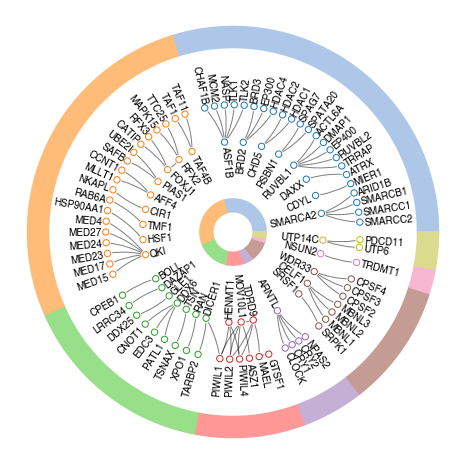

In [45]:
fig = plt.figure(figsize=(6.4,6.4))
ax = plt.subplot(1,1,1, projection='polar')


xticks = []
tc = 0
for cat, r in dfng.iterrows():
    #
    value = r['items']
    order = r['order']
    facecolor = dict_facecolor[order]
    edgecolor = dict_edgecolor[order]
    # Outer rim
    r0, r1 = 4.5, 5
    t0, t1 = tc, (tc + (it * value))
    n = 50
    xy = [(tx, r0) for tx in np.linspace(t0, t1, n)] + [(tx, r1) for tx in np.linspace(t1, t0, n)]
    p = patches.Polygon(xy, closed=True, color=edgecolor, lw=2)
    xticks.append(t0)
    ax.add_patch(p)

    # Annotate patch
    t, r = t0 + ((t1 - t0) / 2), (r1 + 0.2)
    rotation = t * (180 / np.pi) # to degrees
    if (rotation > 90) and (rotation < 270):
        ha = 'right'
        rotation += 180
    else:
        ha = 'left'
    #ax.plot(t,r ,marker='o', color=facecolor)
    #ax.annotate(cat, xy=(t,r), xytext=(t,r), rotation=0, ha=ha, va='center')

    # Inner rim
    r0, r1 = 0.5, .8
    n = 20
    xy = [(tx, r0) for tx in np.linspace(t0, t1, n)] + [(tx, r1) for tx in np.linspace(t1, t0, n)]
    p = patches.Polygon(xy, closed=True, color=edgecolor, lw=2)
    ax.add_patch(p)
    
    # Nodes
    dfnt = dfn.loc[(dfn['cat'] == cat), :].copy()
    for idx, grp in dfnt.groupby(['idx-radius'], sort=True):
        nit = (t1 - t0) / (len(grp) + 1) # node-item-theta
        tn = t0 + (nit * grp['idx-theta'])
        dfn.loc[grp.index, 'radius'] = idx
        dfn.loc[grp.index, 'theta'] = tn
    #
    tc = t1
    
    
# Draw Nodes / Edges
dict_records = dfn.to_dict(orient='index')
pos = {k: [v['theta'], v['radius']] for k, v in dict_records.items()}
node_edgecolors = [v['facecolor'] for k,v in dict_records.items()]
nx.draw_networkx_nodes(G, pos=pos, ax=ax, node_size=40, node_color='white', edgecolors=node_edgecolors)
lfap = nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color='black', arrowstyle='-', alpha=.5, line_width=2, connectionstyle="arc3,rad=0.1")
for fap in lfap:
    fap.shrinkA = 5
    fap.shrinkB = 5

labels = {k: v['name'] for k,v in dict_records.items() if 'theta' in v}
#nx.draw_networkx_labels(G, pos, ax=ax, labels=labels, color='gray',
#                        font_size=8, font_family='Helvetica', verticalalignment='top')
for (k,label), (_,(t,r)) in zip(labels.items(), pos.items()):
    rotation = t * (180 / np.pi) # to degrees
    if (rotation > 90) and (rotation < 270):
        if r > 2.5:
            ha = 'right'
            rt = r + 0.1
        else:
            ha = 'left'
            rt = r - 0.1
        rotation += 180
    else:
        if r > 2.5:
            ha = 'left'
            rt = r + 0.1
        else:
            ha = 'right'
            rt = r - 0.1

    ax.annotate(label, xy=(t,r), xytext=(t,rt), rotation=rotation, ha=ha, va='center', rotation_mode='anchor')

ax.axis('off')
#ax.axes.get_yaxis().set_visible(False)
#ax.set_xticks(xticks)
#ax.set_yticks([])
ax.set_ylim(0, 5.5)
ax.grid(False)

#plt.tight_layout()
plt.subplots_adjust(left=0.01, bottom=0.01, right=0.99, top=0.99)
plt.savefig('images/selected-ortho-backbone/key-orthoedges-genetic-identity.pdf')